Cell 2 — Checar ambiente (Colab):
Executa uma checagem rápida do ambiente: versão do TensorFlow e GPUs disponíveis. Não instala TensorFlow para evitar conflitos no runtime do Colab.

In [ ]:
import tensorflow as tf
import sys
import numpy as np
print('Python:', sys.version.split()[0])
print('TensorFlow:', tf.__version__)
gpus = tf.config.list_physical_devices('GPU')
print('GPUs found:', len(gpus))
if gpus:
    print(gpus)

Cell 3 — Montar Google Drive (opcional):
Se quiser salvar modelos no seu Drive, execute a célula abaixo (apenas em Colab).

In [ ]:
# Execute esta célula somente no Colab se quiser salvar/recuperar arquivos do Google Drive
try:
    import google.colab
    IN_COLAB = True
except Exception:
    IN_COLAB = False

if IN_COLAB:
    from google.colab import drive
    drive.mount('/content/drive')
    print('Drive montado em /content/drive')
else:
    print('Não em Colab — pulando montagem do Drive')

Cell 4 — Baixar e extrair dataset:
Usamos `tf.keras.utils.get_file` para baixar de forma confiável no Colab. A célula baixa e extrai o arquivo zip contendo o dataset cats_and_dogs_filtered.

In [ ]:
import tensorflow as tf
import zipfile
from pathlib import Path

dataset_zip = tf.keras.utils.get_file('cats_and_dogs_filtered.zip',
                                          'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip',
                                          extract=False)

# Extrai para a pasta atual (se ainda não extraído)
extract_dir = Path(dataset_zip).with_suffix('')
if not extract_dir.exists():
    with zipfile.ZipFile(dataset_zip, 'r') as zf:
        zf.extractall(path='.')
    print('Dataset extraído em', extract_dir)
else:
    print('Dataset já extraído em', extract_dir)

Cell 5 — Limpar arquivo zip (opcional):
Remove o arquivo zip baixado para economizar espaço. Em Colab isso é opcional porque `get_file` mantém cache.

In [ ]:
import os
if os.path.exists('cats_and_dogs_filtered.zip'):
    try:
        os.remove('cats_and_dogs_filtered.zip')
        print('Arquivo zip removido')
    except Exception as e:
        print('Falha ao remover zip:', e)
else:
    print('Zip não existe — possivelmente já removido pelo gerenciador de arquivos.')

Cell 6 — Importar bibliotecas e configurar paths:
Define diretórios de treino/validação e conta número de amostras.

In [ ]:
import os
from pathlib import Path

dataset_dir = Path.cwd() / 'cats_and_dogs_filtered'
dataset_train_dir = dataset_dir / 'train'
dataset_validation_dir = dataset_dir / 'validation'

dataset_train_cats_len = len(list((dataset_train_dir / 'cats').glob('*')))
dataset_train_dogs_len = len(list((dataset_train_dir / 'dogs').glob('*')))
dataset_validation_cats_len = len(list((dataset_validation_dir / 'cats').glob('*')))
dataset_validation_dogs_len = len(list((dataset_validation_dir / 'dogs').glob('*')))

print('Train Cats:', dataset_train_cats_len)
print('Train Dogs:', dataset_train_dogs_len)
print('Validation Cats:', dataset_validation_cats_len)
print('Validation Dogs:', dataset_validation_dogs_len)

Train Cats: 1000
Train Dogs: 1000
Validation Cats: 500
Validation Dogs: 500


Cell 7 — Hiperparâmetros e formas de imagem (simplificado):
Valores reduzidos (épocas curtas) para um minicurso; ajuste conforme necessário.

In [ ]:
# Configurações simples para minicurso
image_width = 160
image_height = 160
image_color_channel = 3
image_color_channel_size = 255
image_size = (image_width, image_height)
image_shape = image_size + (image_color_channel,)
batch_size = 32
# Para um minicurso, usar poucas épocas — aumente para produção
epochs = 5
learning_rate = 1e-4
class_names = ['cat', 'dog']

Cell 8 — Carregar datasets com image_dataset_from_directory:
Cria `tf.data.Dataset` a partir das pastas `train` e `validation`. Função do Keras que funciona bem no Colab.

In [ ]:
import tensorflow as tf
dataset_train = tf.keras.preprocessing.image_dataset_from_directory(str(dataset_train_dir),
                                                    image_size=image_size,
                                                    batch_size=batch_size,
                                                    shuffle=True)
dataset_validation = tf.keras.preprocessing.image_dataset_from_directory(str(dataset_validation_dir),
                                                         image_size=image_size,
                                                         batch_size=batch_size,
                                                         shuffle=True)


Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.


Cell 9 — Prefetch para performance:
Aplica prefetch para melhorar throughput durante o treino. Mantemos dataset_test apontando para validation para simplificar.

In [9]:
autotune = tf.data.AUTOTUNE
dataset_train = dataset_train.prefetch(buffer_size=autotune)
dataset_validation = dataset_validation.prefetch(buffer_size=autotune)
dataset_test = dataset_validation

Cell 10 — Visualizar imagens do dataset:
Função para plotar algumas imagens do dataset; útil para entender o que está sendo treinado.

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
def plot_dataset(dataset):
    plt.gcf().clear()
    plt.figure(figsize=(9,9))
    for images, labels in dataset.take(1):
        for i in range(9):
            plt.subplot(3,3,i+1)
            plt.imshow(images[i].numpy().astype('uint8'))
            plt.axis('off')
            plt.title(class_names[int(labels[i])])
    plt.show()

<Figure size 640x480 with 0 Axes>

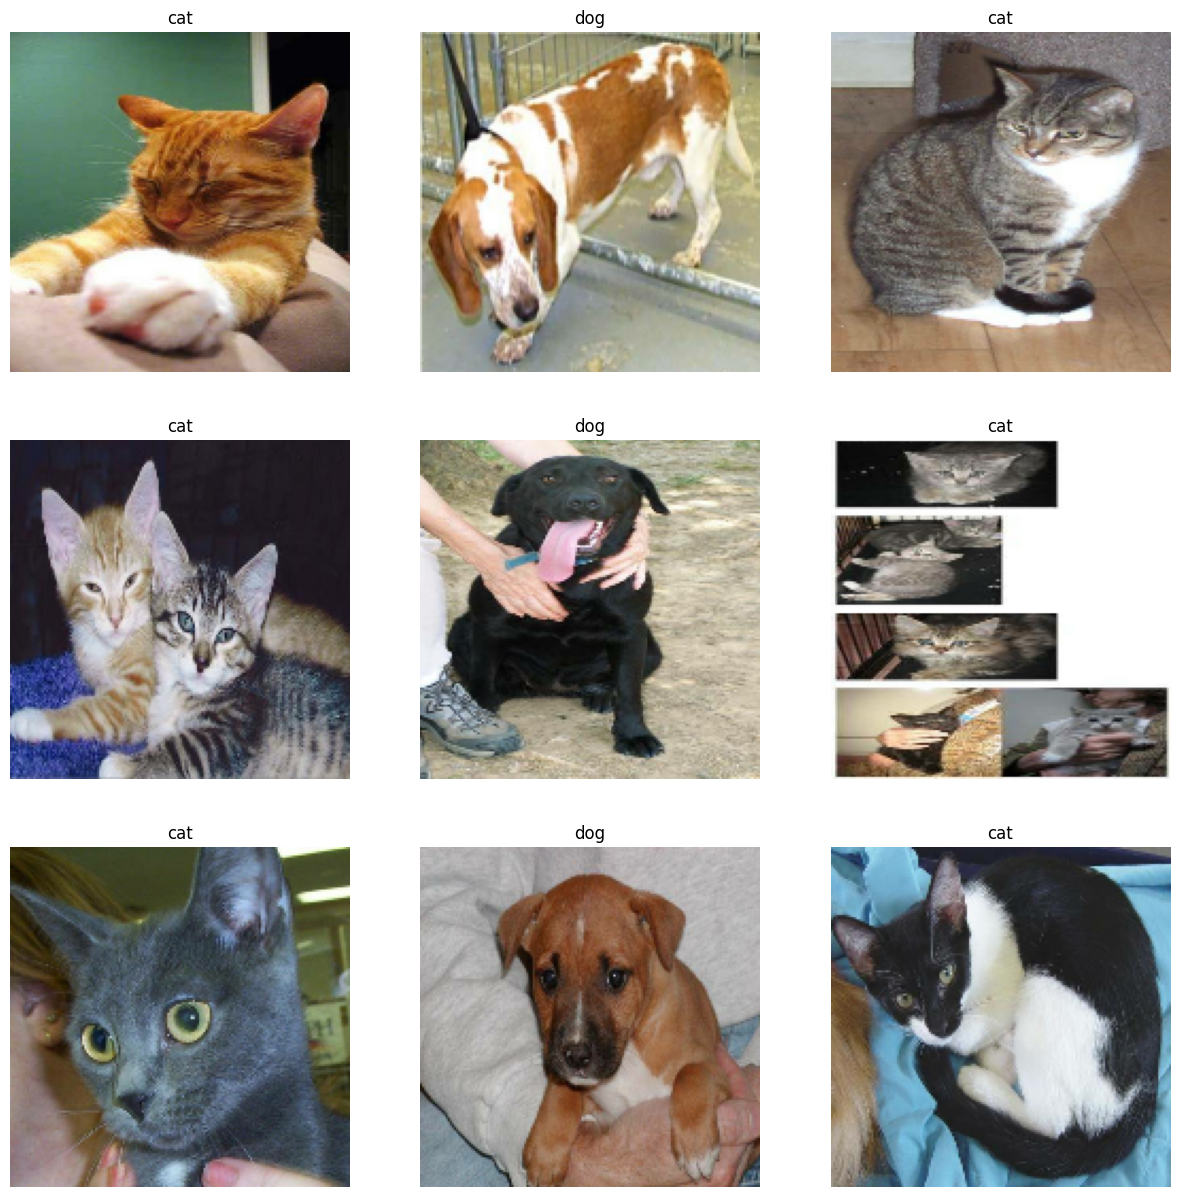

In [11]:
plot_dataset(dataset_train)

<Figure size 640x480 with 0 Axes>

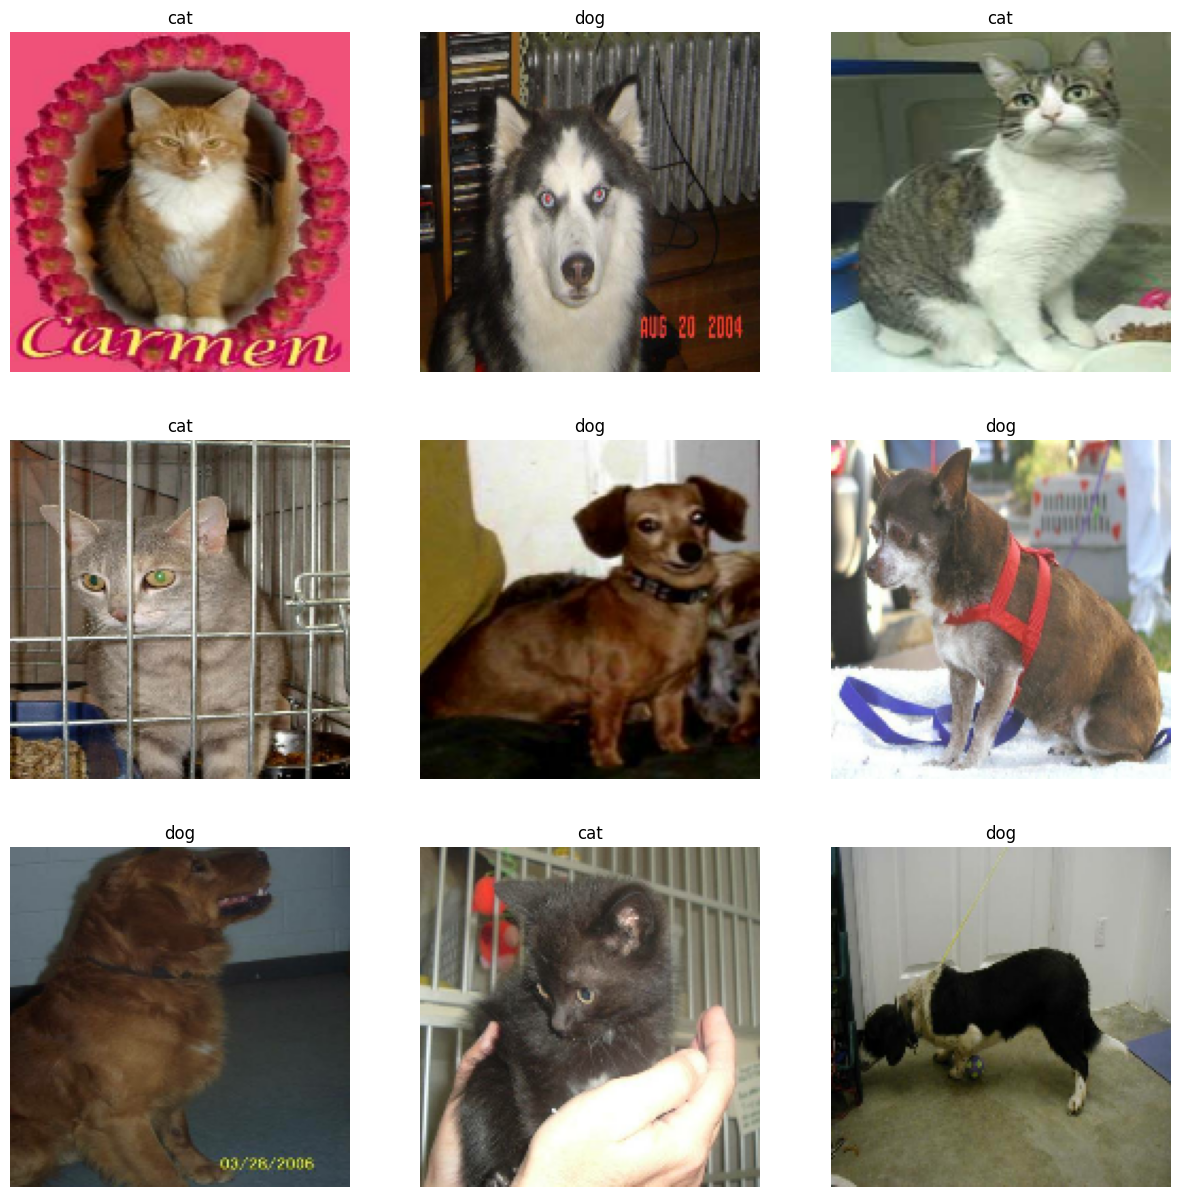

In [ ]:
plot_dataset(dataset_validation)

<Figure size 640x480 with 0 Axes>

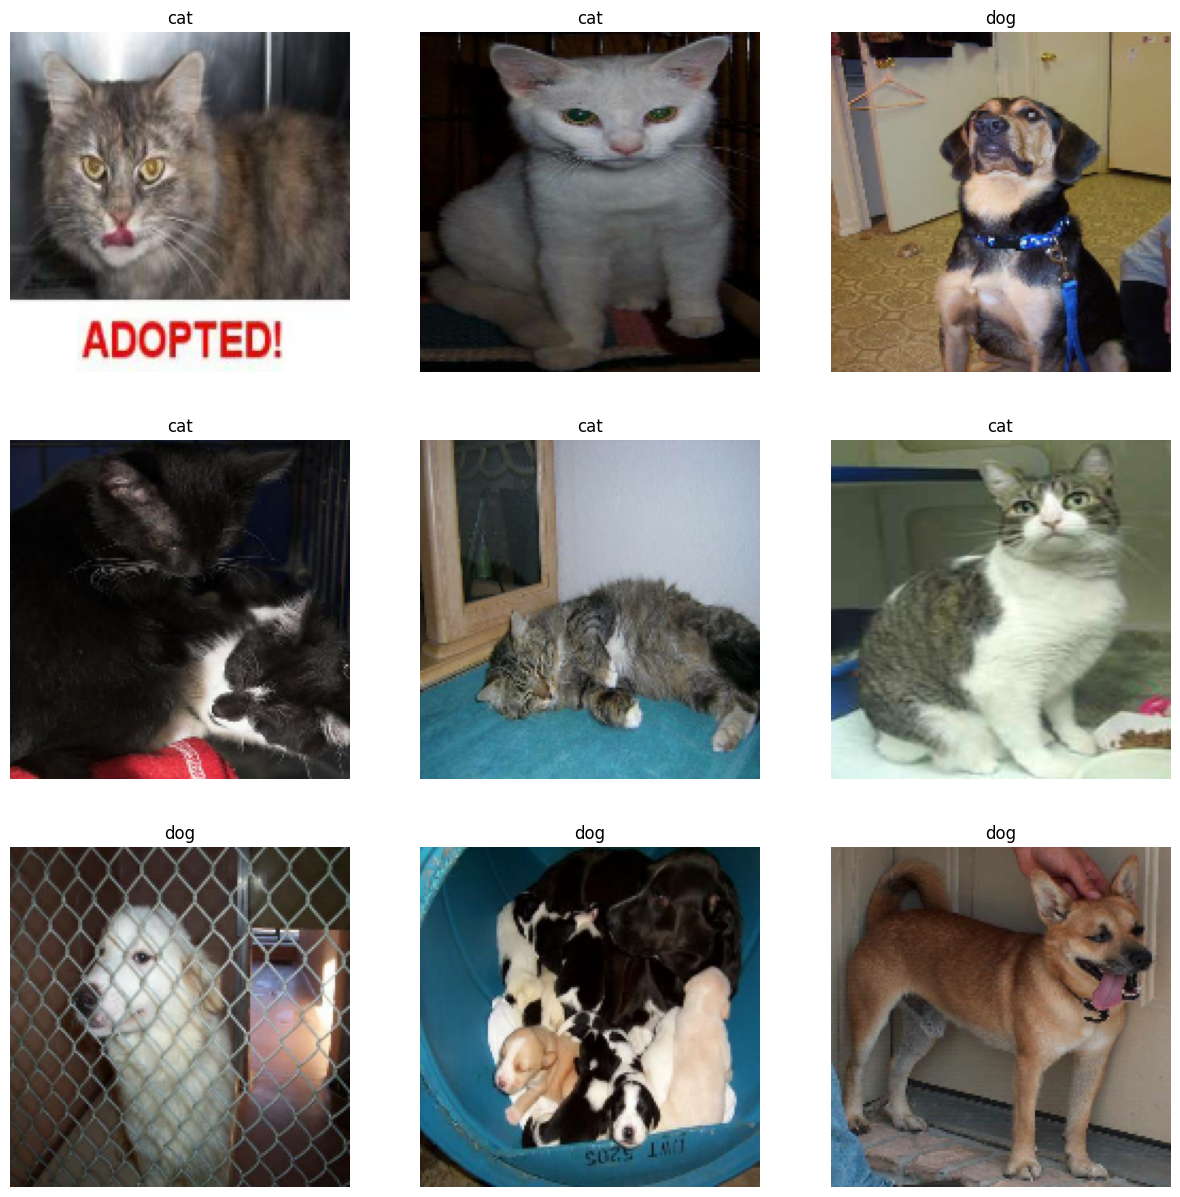

In [13]:
plot_dataset(dataset_test)

Cell 11 — Data augmentation (simples):
Cria pequenas transformações aleatórias aplicadas on-the-fly durante o treino para melhorar generalização.

In [15]:
data_augmentation = tf.keras.models.Sequential([
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
])

Cell 12 — Normalização e backbone (transfer learning):
Define camada de rescaling e cria MobileNetV2 como backbone (pesos ImageNet). Mantemos o backbone congelado para acelerar o treino no minicurso.

In [ ]:
rescaling = tf.keras.layers.Rescaling(1. / (image_color_channel_size / 2.), offset=-1, input_shape=image_shape)
model_transfer_learning = tf.keras.applications.MobileNetV2(input_shape=image_shape, include_top=False, weights='imagenet')
model_transfer_learning.trainable = False

c:\GitHub\ProjetosPessoais\redeNeuralArtificial\.venv\Lib\site-packages\keras\src\layers\preprocessing\tf_data_layer.py:18: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Cell 13 — Montar modelo final e compilar:
Empilha as camadas finais (GlobalAveragePooling, Dropout, Dense) e compila o modelo com BinaryCrossentropy.

In [21]:
model = tf.keras.models.Sequential([
    rescaling,
    data_augmentation,
    model_transfer_learning,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

Cell 14 — Callbacks e treino:
Usa EarlyStopping para interromper treino quando não há melhoria e salva o modelo ao final.

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
history = model.fit(dataset_train, validation_data=dataset_validation, epochs=epochs, callbacks=[early_stopping])
model.save('model.keras')
print('Modelo salvo em model.keras')

Epoch 1/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 37s 466ms/step - accuracy: 0.5695 - loss: 0.7856 - val_accuracy: 0.7750 - val_loss: 0.5153
Epoch 2/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 26s 414ms/step - accuracy: 0.6967 - loss: 0.5871 - val_accuracy: 0.8880 - val_loss: 0.3737
Epoch 3/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 26s 416ms/step - accuracy: 0.8052 - loss: 0.4487 - val_accuracy: 0.9320 - val_loss: 0.2909
Epoch 4/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 28s 441ms/step - accuracy: 0.8304 - loss: 0.4014 - val_accuracy: 0.9450 - val_loss: 0.2386
Epoch 5/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 27s 432ms/step - accuracy: 0.8526 - loss: 0.3563 - val_accuracy: 0.9550 - val_loss: 0.2024
Epoch 6/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 27s 425ms/step - accuracy: 0.8794 - loss: 0.3152 - val_accuracy: 0.9580 - val_loss: 0.1780
Epoch 7/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 30s 484ms/step - accuracy: 0.8828 - loss: 0.2892 - val_accuracy: 0.9600 - val_loss: 0.1597
Epoch 8/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 47s 558ms/step - accuracy: 0.8871 - loss: 0.2844 - val_accu

: 

Cell 15 — Plots de treino e avaliação:
Funções para plotar curvas de treino e avaliar no conjunto de validação/teste.

In [22]:
import matplotlib.pyplot as plt
def plot_model(history):
    acc = history.history.get('accuracy', [])
    val_acc = history.history.get('val_accuracy', [])
    loss = history.history.get('loss', [])
    val_loss = history.history.get('val_loss', [])
    epochs_range = range(len(acc))
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.plot(epochs_range, acc, label='train_acc')
    plt.plot(epochs_range, val_acc, label='val_acc')
    plt.legend()
    plt.title('Accuracy')
    plt.subplot(1,2,2)
    plt.plot(epochs_range, loss, label='train_loss')
    plt.plot(epochs_range, val_loss, label='val_loss')
    plt.legend()
    plt.title('Loss')
    plt.show()

In [24]:
# Avaliar no conjunto de validação (ou teste) e mostrar métricas
results = model.evaluate(dataset_test)
print('Test loss:', results[0])
print('Test accuracy:', results[1])

32/32 ━━━━━━━━━━━━━━━━━━━━ 11s 255ms/step - accuracy: 0.5567 - loss: 0.7328
Dataset Test Loss:     0.7079207301139832
Dataset Test Accuracy: 0.5720000267028809


In [ ]:
def plot_dataset_predictions(dataset):
    features, labels = next(iter(dataset_test))
    predictions = (model.predict_on_batch(features).flatten() > 0.5).astype(int)
    plt.figure(figsize=(9,9))
    for i in range(9):
        plt.subplot(3,3,i+1)
        plt.imshow(features[i].numpy().astype('uint8'))
        plt.axis('off')
        plt.title(class_names[predictions[i]])
    plt.show()

Labels:      [0 0 0 0 1 0 0 1 0 0 1 0 0 0 0 1 1 1 0 1 0 1 0 0 0 0 0 1 0 0 0 1]
Predictions: [1 1 1 1 1 0 1 1 0 0 1 0 0 1 0 0 1 1 0 1 1 1 1 0 0 1 1 0 1 0 0 1]


<Figure size 640x480 with 0 Axes>

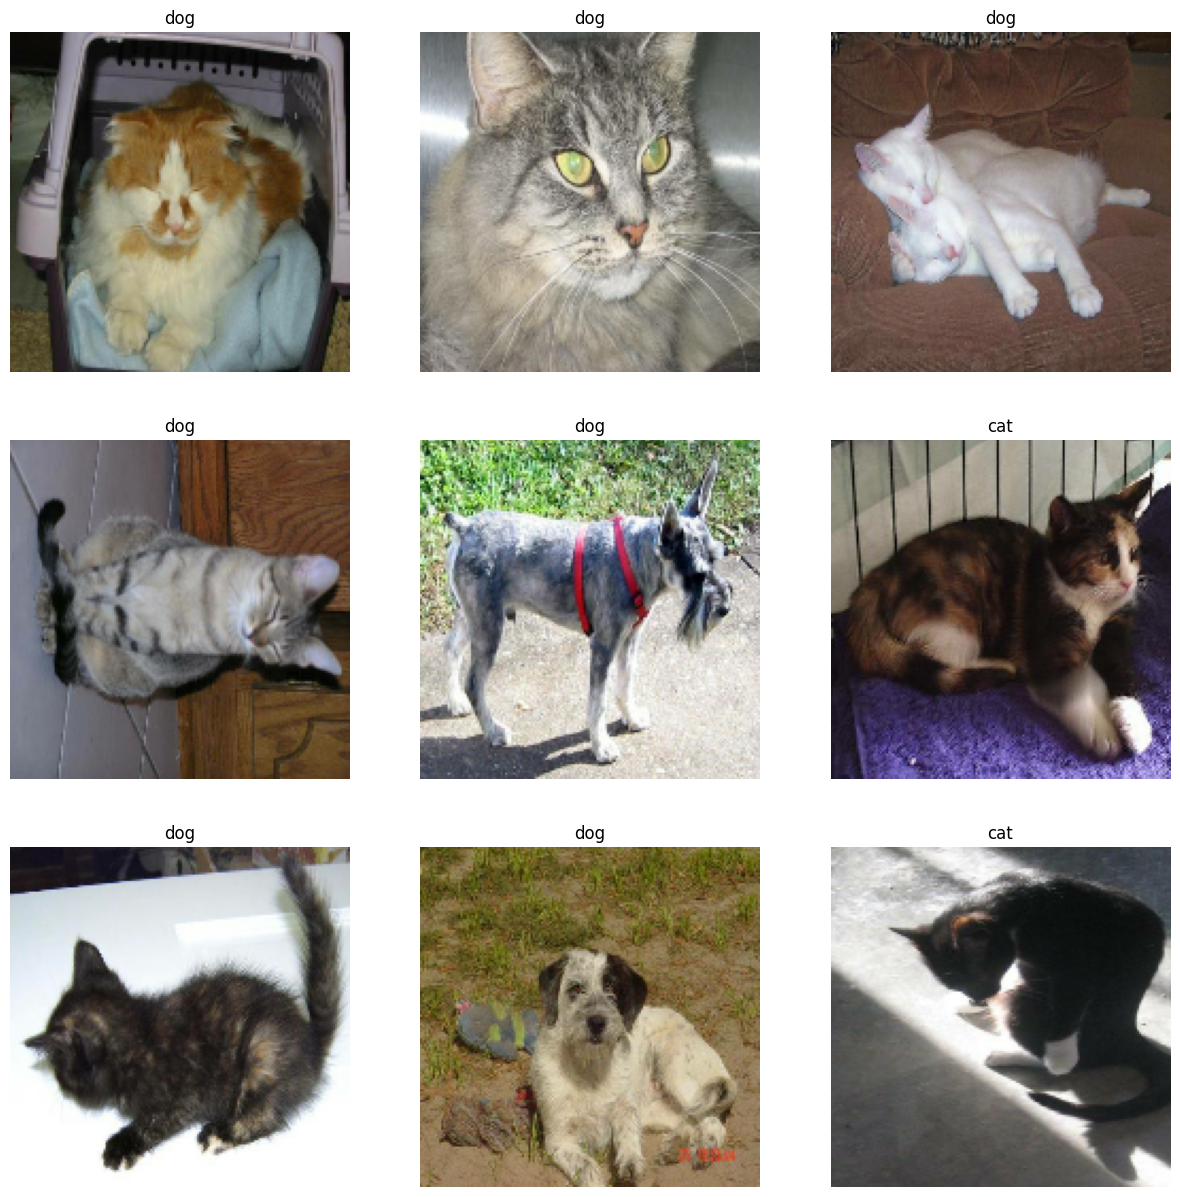

In [26]:
plot_dataset_predictions(dataset_test)

Cell 16 — Carregar modelo salvo e funções de inferência:
Mostra como carregar o modelo salvo `model.keras` e prever a partir de um arquivo local ou URL.

In [27]:
import tensorflow as tf
model = tf.keras.models.load_model('model.keras')
print('Modelo carregado de model.keras')

In [ ]:
def predict(image_file):
    image = tf.keras.preprocessing.image.load_img(image_file, target_size=image_size)
    image = tf.keras.preprocessing.image.img_to_array(image)
    image = tf.expand_dims(image, 0)
    prediction = model.predict(image)[0][0]
    label = 'cat' if prediction < 0.5 else 'dog'
    print(f'Prediction: {prediction:.4f} -> {label}')

In [29]:
def predict_url(image_fname, image_origin):
    image_file = tf.keras.utils.get_file(image_fname, origin=image_origin)
    return predict(image_file)